# [음성 감정 인식](https://www.kaggle.com/c/2021-ml-tp-p6)
> 2021학년도 1학기 기계학습 텀프로젝트 \#3

# 코드 시작 전 설명
1. 음성 데이터에 대한 이론 및 과정을 잘 모르시는 분은 코드를 작성하기 전 overview를 한번 정독하시는 것을 권합니다.

2. 스켈레톤 코드가 적혀있는 해당 ipynb 파일을 다운받아 자신의 작업공간(코랩, 캐글노트북 등등)에서 코드를 작성합니다.

3. 각 코드에는 빈칸과 함께 구현 가이드 라인이 제공됩니다. 해당 가이드라인을 따라 코드를 작성하여 베이스 라인 성능을 달성합니다.
   진행에 어려움이 있으신 경우에는 feature 가공에 사용되는 함수의 documentation 설명을 읽으시는 것을 권합니다.
   
4. (선택)베이스라인에 도달하였다면, 음성 feature를 새롭게 가공하여 추가적인 성능 향상을 달성해봅니다.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ml-tp-p6/train_data.csv
/kaggle/input/2021-ml-tp-p6/test_data.csv
/kaggle/input/2021-ml-tp-p6/sample_submit.csv
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_132.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_185.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_268.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_344.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_093.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_131.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_327.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_120.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_064.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_371.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_028.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_250.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_408.wav
/kaggle/input/2021-ml-tp-p6/test_data/test_data/test_334.wav
/kaggle/input/2

In [2]:
import pandas as pd
import numpy as np
import sklearn
import os
from os.path import join

import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from collections import defaultdict

In [3]:
#DATA Load

DATA_PATH = join('/kaggle','input','2021-ml-tp-p6')
pd_train = pd.read_csv(join(DATA_PATH, 'train_data.csv'))
pd_test = pd.read_csv(join(DATA_PATH, 'test_data.csv'))
sample = pd.read_csv(join(DATA_PATH,'sample_submit.csv'))

print(pd_train.info(), pd_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1008 non-null   int64 
 1   file_name  1008 non-null   object
 2   emotion    1008 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         432 non-null    int64 
 1   file_name  432 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.9+ KB
None None


# **Feature 추출**

* extract_feature 함수는 음성 데이터를 읽어서 다음의 과정들을 거치며 feature를 추출합니다.(함수(입력) --> 출력)
 1. Sampling&Quantization(continuos audio signal) --> Discrete audio signal
 2. Short Time Fourier Transfrom(Discrete audio signal) --> Spectrogram
 3. Mel-Filter(Spectrogram) --> Mel-Spectrogram
 4. Discrete Cosine Transform(Mel-Spectrogram) --> Mel Frequency Cepstrum Coefficient
 
위에 과정들은 모두 librosa 라이브러리에서 제공하는 함수들을 통하여 구현가능하며 사용되는 함수는 다음과 같습니다.

1. librosa.load : Continuos audio signal(.wav파일)을 Discrete audio signal로 읽음. 
2. librosa.stft : Discrte audio signal을 windowing하여 프레임별로 나눈 후 FFT(Fast Fourier Transform)을 수행
[stft_documentation](https://librosa.org/doc/latest/generated/librosa.stft.html?highlight=stft)
3. librosa.feature.melspectrogram : stft 함수를 통하여 구한 spectrogram을 입력으로 Mel-filter를 적용함으로써 Mel-Spectrogram 생성[melspectrogram_documentation](https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html?highlight=melspectrogram)
4. librosa.feature.mfcc : melspectrogram 함수를 통하여 구한 Mel-spectrogram을 입력으로 DCT를 수행함으로써 MFCC를 생성 [mfcc_documentation](https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html?highlight=mfcc)

----
### extract_feature() 과정

In [4]:
import librosa

In [5]:
file_path = join(DATA_PATH, 'train_data', 'train_data', 'train_000.wav')

X, sample_rate = librosa.load(file_path, sr = 22050 * 2)
n_fft = 512 * 2

In [6]:
print(X)
print(sample_rate, X.shape) # sample_rate 가 22050 * 2 이므로 3초 가량 되는 것을 알 수 있다.
print(X.shape[0]/sample_rate)

[0.000000e+00 0.000000e+00 0.000000e+00 ... 1.317525e-09 5.288735e-08
 0.000000e+00]
44100 (154505,)
3.503514739229025


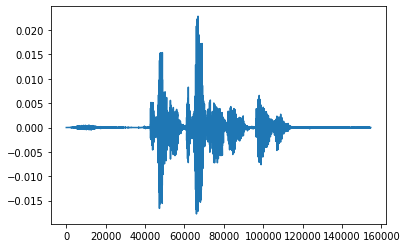

In [7]:
import matplotlib.pyplot as plt

plt.plot(X)
plt.show()

In [8]:
spectrogram = np.abs(librosa.stft(X, n_fft=n_fft))
print(spectrogram)
print(spectrogram.shape) # (frequency의 길이, 프레임 수)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.7244322e-03
  6.4353053e-03 2.8395436e-03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.6407585e-03
  5.8232145e-03 1.2048723e-03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.9389168e-03
  4.8769293e-03 1.7305556e-03]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3319594e-11
  8.7149745e-09 5.6129096e-08]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.0117663e-11
  8.6899652e-09 5.6143147e-08]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.5239858e-12
  8.6596490e-09 5.6090194e-08]]
(513, 604)


In [9]:
spectrogram_feature = np.mean(spectrogram, axis=1)
print(spectrogram_feature.shape)

(513,)


In [10]:
power_spectrogram = spectrogram ** 2
mel_spectrogram_power = librosa.feature.melspectrogram(S=power_spectrogram, n_fft=n_fft)
mel_spectrogram_power.shape

(128, 604)

In [11]:
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_power)
mel_spectrogram_feature = np.mean(mel_spectrogram_db, axis=1)
mel_spectrogram_feature.shape

(128,)

In [12]:
mfcc = librosa.feature.mfcc(S=mel_spectrogram_db)
mfcc.shape

(20, 604)

In [13]:
mfcc_feature = np.mean(mfcc, axis=1)
mfcc_feature.shape

(20,)

In [14]:
import librosa
import glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import librosa, librosa.display 


# -------------------------------------
# extract_feature(file_name): <= 코드를 추가하여 음성 feature를 추출하는 코드를 완성하세요
# -------------------------------------
# 목적: MFCC를 비롯한 여러 음성 feature를 추출
# 입력인자: .wav 음성 파일의 이름
# 출력인자: 입력 파일을 가공한 feature들 (Spectrogram, Mel-spectrogram, MFCC)
# -------------------------------------


def extract_feature(file_name):
    
    
    # result=np.array([])
    X, sample_rate = librosa.load(file_name, sr=22050 * 2) # stft() 에서 n_fft 는 sr 22050Hz
    n_fft = 512 * 2 # 내가 사용할 n_fft parameter -> 512: 23ms
    #----------step3. spectrogram을 구하세요.---------------------
    # 구현 가이드 라인(3)
    # ------------------------------------------------------------------------------
    # 1. 입력 신호(X)를 librosa.stft 함수의 입력으로 하여 spectrogram을 구하세요.
    #   -참고) 사람의 음성은 20~40(ms) 사이 시간 내에서 현재 말하는 발음을 변경할 수 없다고 합니다.
    #       시간축에 대한 구간을 나눌 때 20~40(ms) 이내 간격으로 나누기 위하여 n_fft 파라미터 값을 조정해주세요.(베이스라인 성능은 23ms 간격으로 나누었습니다.)
    #       정확한 조정을 위하여 librosa documentation에서 librosa.stft 함수 내 n_fft 파라미터 설명을 참조하세요.
    #
    # 2. spectrogram에 절대값을 취하여 복소수 형태의 값을 바꾸세요.
    #
    # 3. 구한 spectrogram을 학습에 사용하기 위하여 프레임 축의 평균값을 취한 뒤 spectrogram_feature에 저장해주세요
    #   -참고) spectrogram의 shape은 (frequency의 길이, 프레임 수)로 이루어져있습니다.
    #       (np.mean함수를 사용하여 spectrogram의 shape이 (1, frequency의 길이)가 되면 성공.)
    # -----------------------------------------------------------------------------
    
    # 1, 2
    spectrogram = np.abs(librosa.stft(X, n_fft=n_fft))
    # 3
    spectrogram_feature = np.mean(spectrogram, axis=1)
    
    #------------------------------------------------------------------------------- 
    
    #----------step4. Mel-spectrogram을 구하세요.---------------------
    # 구현 가이드 라인(4)
    # ------------------------------------------------------------------------------
    # 1. step3-2에서 구한 spectrogram을 제곱하여 power spectrogram을 만드세요.
    #
    # 2. power spectrogram을 librosa.feature.melspectrogram 함수의 입력으로 하여 mel-spectrogram을 구하세요.
    #   - 참고) documentation을 통해 librosa.feature.melspectrogram 함수의 입력 인자를 꼭 확인하셔서 올바르게 넣어주세요
#####      -> librosa.feature.melspectogram() 의 n_fft=2048 (default) -> 변경해주어야함
#####      -> 입력인자 y가 아니라 S에 대입해야한다. 
    #
    # 3. step4-2에서 구한 mel-spectrogram은 power-magnitude 값입니다. librosa.power_to_db함수를 통하여 power magnitude를 데쉬벨(db)로 변환하세요.
    #
    # 4. 구한 mel-spectrogram을 학습에 사용하기 위하여 프레임 축의 평균값을 취한 뒤 mel_spectrogram_feature에 저장해주세요
    #   -참고) mel-spectrogram의 shape은 (mel filter의 길이, 프레임 수)로 이루어져있습니다.
    #       (np.mean함수를 사용하여 mel-spectrogram의 shape이 (1, mel filter의 길이)가 되면 성공.)
    # -----------------------------------------------------------------------------
    
    # 1
    power_spectrogram = spectrogram ** 2
    # 2
    mel_spectrogram_power = librosa.feature.melspectrogram(S=power_spectrogram, n_fft=n_fft)
    # 3
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_power)
    # 4
    mel_spectrogram_feature = np.mean(mel_spectrogram_db, axis=1)
    
    
    #-------------------------------------------------------------------------------

    #----------step5. MFCC를 구하세요.---------------------
    # 구현 가이드 라인(5)
    # ------------------------------------------------------------------------------ 
    # 1. step4-3에서 데쉬벨로 변환한 mel-spectrogram을 librosa.feature.mfcc 함수의 입력으로 하여 MFCC를 구하세요.
    #   - 참고) documentation을 통해 librosa.feature.mfcc 함수의 입력 인자를 꼭 확인하셔서 올바르게 넣어주세요.
#####      -> S에 입력인자 대입
    #
    # 2. 구한 MFCC 학습에 사용하기 위하여 프레임 축의 평균값을 취한 뒤 mfcc_feature에 저장해주세요
    # -참고) MFCC shape은 (MFCC의 길이, 프레임 수)로 이루어져있습니다.
    #       (np.mean함수를 사용하여 MFCC의 shape이 (1, MFCC의 길이)가 되면 성공.)
    # -----------------------------------------------------------------------------
    
    # 1
    mfcc = librosa.feature.mfcc(S=mel_spectrogram_db)
    # 2
    mfcc_feature = np.mean(mfcc, axis=1)
    #-------------------------------------------------------------------------------

    return spectrogram_feature, mel_spectrogram_feature, mfcc_feature 

# **데이터 불러오기**

### csv파일에 저장된 파일 이름과 학습용 label을 로드하여 학습 및 평가용 데이터를 불러오세요.

In [15]:
#DataFlair - Load the data and extract features for each sound file
from tqdm import tqdm
def load_data(data_info, isTrain=True):
    
    PATH = join('/kaggle','input','2021-ml-tp-p6')
    if isTrain:
        train_data = {'spectrogram':[],'mel':[],'mfcc':[]}#음성 feature들을 담는 dictionary
        train_label = []#학습에 사용할 label을 담는 list
        
        file_list = data_info['file_name']
        emotion_list = data_info['emotion']
        
        for file_name, emotion in tqdm(zip(file_list, emotion_list)):
            # ------------- step1. 학습용 데이터로더 코드를 작성하세요.----------------------
            # 구현 가이드라인  (1)
            # ------------------------------------------------------------
            # train.csv 파일에 있는 음성 파일의 이름과 emotion 정보를 통하여 학습용 데이터를 로드하세요.
            # 음성 파일의 정확한 경로 명을 extract_feature 함수의 입력으로 넣을 수 있게 경로를 잘 설정해보세요.
#############    -> train_data/train_data/ 에 들어있는 것 주의!            
            # extract_feature를 통해 구한 음성 feature들을 train_data 사전 속 배열에 알맞게 append 해주세요. ex) train_data['spectrogram'].append(spectrogram_feature)
            # ------------------------------------------------------------
            # 구현 가이드라인을 참고하여 코드를 작성해보세요.
            
            spectrogram_feature, mel_spectrogram_feature, mfcc_feature = \
                extract_feature(join(PATH, 'train_data', 'train_data', file_name))
            train_data['spectrogram'].append(spectrogram_feature)
            train_data['mel'].append(mel_spectrogram_feature)
            train_data['mfcc'].append(mfcc_feature)
            
            train_label.append(emotion)
            
            #----------------------------------------------------------------------------------------- 
            
        return train_data, np.array(train_label)
    
    else:
        test_data = {'spectrogram':[],'mel':[],'mfcc':[]}#음성 feature들을 담는 dictionary
        
        file_list = data_info['file_name']
    
        for file_name in tqdm(file_list):
            # -------------step2. 평가용 데이터로더 코드를 작성하세요.-----------------
            # 구현 가이드라인  (2)
            # ------------------------------------------------------------
            # test.csv 파일에 있는 음성 파일의 이름정보를 통하여 평가용 데이터를 로드하세요.
            # 음성 파일의 정확한 경로 명을 extract_feature 함수의 입력으로 넣을 수 있게 경로를 잘 설정해보세요.
            # extract_feature를 통해 구한 음성 feature들을 test_data 사전 속 배열에 알맞게 append 해주세요. ex) test_data['spectrogram'].append(spectrogram_feature)
            # ------------------------------------------------------------
            # 구현 가이드라인을 참고하여 코드를 작성해보세요.
            
            spectrogram_feature, mel_spectrogram_feature, mfcc_feature = \
                extract_feature(join(PATH, 'test_data', 'test_data', file_name))
            test_data['spectrogram'].append(spectrogram_feature)
            test_data['mel'].append(mel_spectrogram_feature)
            test_data['mfcc'].append(mfcc_feature)
            
            #----------------------------------------------------------------------------------------- 
            
        return test_data

#DataFlair - Split the dataset
train_data, y_train = load_data(pd_train)
test_data = load_data(pd_test, isTrain=False)

1008it [03:56,  4.27it/s]
100%|██████████| 432/432 [01:41<00:00,  4.27it/s]


In [16]:
train_data['spectrogram'][0].shape

(513,)

In [17]:
train_data['mel'][0].shape

(128,)

In [18]:
train_data['mfcc'][0].shape

(20,)

# 모델 학습 및 추론
위에서 우리는 
1. 음성 신호에 대하여 Short Time Fourier Transform(stft)를 통해 **spectrogram**을 구하고,
2. 구한 spectrogram에 mel-filter를 씌워 **mel-spectrogram**을 구했으며,
3. 마지막으로 mel-spectrogram에 Discrete cosine transform(DCT) 취해줌으로써 **mfcc**까지 계산하였습니다.

위에서 구한 feature들은 모두 음성 데이터를 활용하는 다양한 작업(사람 음성 분류, 음성을 통한 감정 분류 등)에서 모델 학습에 사용할 수 있는 feature들입니다.
각각의 **feature들에 따른 모델의 정확도가 얼마나 차이**나는지를 확인해봅시다.

- 베이스라인의 분류기는 **RandomForestClassifier**를 사용합니다.
- **random_state에 따른 성능 차이가 발생하오니 반드시 random_state를 1로 고정해주시길 바랍니다.**

In [19]:
#RandomForestClassifier로 음성 감정 분류 학습 및 평가

dt = {}

for feature_name in train_data.keys():
    # ------------- step6. 음성 feature들을 가지고 모델을 학습하세요.----------------------
    # 구현 가이드라인  (6)
    # ------------------------------------------------------------
    # dictionary 형태의 train_data 변수 내에는 spectrogram, mel-spectrogram, mfcc feature들이 존재합니다.
    # 반복문을 통해 각 종류의 feature를 하나씩 불러오세요. ex) x_train = np.array(train_data[feature_name])
    # 불러온 feature로 모델을 학습 및 추론 후 sample submit파일에 저장하세요.
    # ------------------------------------------------------------
    # 구현 가이드라인을 참고하여 코드를 작성해보세요.
    
    X_train = np.array(train_data[feature_name])
    X_test = np.array(test_data[feature_name])
    
    scores = cross_validate(RandomForestClassifier(random_state=1),
                           X_train, y_train, scoring='accuracy',
                           return_train_score=True)
    print(f"### {feature_name} ###")
    for score_type in scores.keys():
        print(f"{score_type}: {scores[score_type]}")
    print(f"mean test score: {np.mean(scores['test_score'])}")
    print()
    
    rf_clf = RandomForestClassifier(random_state=1)
    rf_clf.fit(X_train, y_train)
    
    dt[feature_name] = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
    predict = rf_clf.predict(X_test)
    
    #Sample submit file 저장
    sample['emotion'] = predict.reshape(-1,1)
    sample.to_csv(join(feature_name+'.csv'),index=False,header=True)

#만약 코랩사용시 사용
# !kaggle competitions submit -c 2021-ml-tp-p6 -f spectrogram.csv -m "spectrogram"
# !kaggle competitions submit -c 2021-ml-tp-p6 -f mel.csv -m "mel-spectrogram"
# !kaggle competitions submit -c 2021-ml-tp-p6 -f mfcc.csv -m "mfcc"

### spectrogram ###
fit_time: [0.9378705  0.9070406  0.91803694 0.90682793 0.90763736]
score_time: [0.01494622 0.01494288 0.01471376 0.01473475 0.01483703]
test_score: [0.48019802 0.4950495  0.41584158 0.47761194 0.47263682]
train_score: [1. 1. 1. 1. 1.]
mean test score: 0.4682675730259593

### mel ###
fit_time: [0.70197439 0.69494605 0.70159101 0.68241405 0.68095064]
score_time: [0.01433682 0.01440692 0.01415539 0.0138309  0.01436853]
test_score: [0.46534653 0.41089109 0.44554455 0.4079602  0.39800995]
train_score: [1. 1. 1. 1. 1.]
mean test score: 0.42555046549431064

### mfcc ###
fit_time: [0.37255049 0.38904572 0.38811755 0.38683653 0.37879276]
score_time: [0.01384544 0.01420426 0.01387143 0.01378322 0.01414728]
test_score: [0.5990099  0.52475248 0.52475248 0.51243781 0.53233831]
train_score: [1. 1. 1. 1. 1.]
mean test score: 0.5386581941776268



## Experiment 1 - PCA


In [20]:
#RandomForestClassifier로 음성 감정 분류 학습 및 평가

sample = pd.read_csv(join(DATA_PATH,'sample_submit.csv'))
pca_exp_train_score = defaultdict(list)
pca_exp_test_score = defaultdict(list)

com_divisions = [i for i in range(1, 15)]
for com_division in range(1, 15):
    for feature_name in train_data.keys():

        X_train = np.array(train_data[feature_name])
        X_test = np.array(test_data[feature_name])

        n_components = X_train.shape[1] // com_division
        pca = PCA(n_components=n_components,
                  random_state=42).fit(X_train)

        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        scores = cross_validate(RandomForestClassifier(random_state=1),
                               X_train, y_train, scoring='accuracy',
                               return_train_score=True)
        pca_exp_train_score[feature_name]\
            .append(np.mean(scores['train_score']))
        pca_exp_test_score[feature_name]\
            .append(np.mean(scores['test_score']))

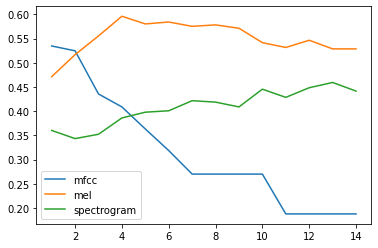

In [21]:
plt.plot(com_divisions, pca_exp_test_score['mfcc'], label='mfcc')
plt.plot(com_divisions, pca_exp_test_score['mel'], label='mel')
plt.plot(com_divisions, pca_exp_test_score['spectrogram'], label='spectrogram')
plt.legend()

In [22]:
pca_exp_test_score['mel']

[0.4712723511157086,
 0.5168415348997587,
 0.555514506674548,
 0.5962317127235112,
 0.5803211664450026,
 0.5843357470075365,
 0.5753509679326141,
 0.5783458942909216,
 0.5714053494901729,
 0.5415989360130042,
 0.5316979459139943,
 0.5465839121225555,
 0.5287424264814542,
 0.5287424264814542]

In [23]:
np.array(train_data['mel']).shape[1] // 4

32

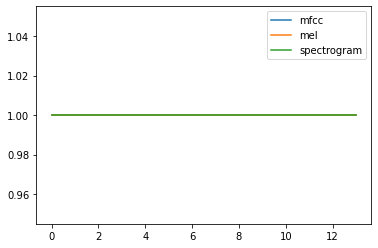

In [24]:
# 모두 1.0 이어서 하나로 겹쳐져 보임
plt.plot(pca_exp_train_score['mfcc'], label='mfcc')
plt.plot(pca_exp_train_score['mel'], label='mel')
plt.plot(pca_exp_train_score['spectrogram'], label='spectrogram')
plt.legend()

## Experiment 3 - parameter tuning

In [25]:
# 구현가이드라인(6) 에서 추후 파라미터 조정을 위해 DT를 학습해두었다.
for feature_name in train_data.keys():
    print(f"{feature_name} DT depth: {dt[feature_name].get_depth()}")

spectrogram DT depth: 19
mel DT depth: 18
mfcc DT depth: 19


In [26]:
X_train = np.array(train_data['mfcc'])
X_test = np.array(test_data['mfcc'])

param_grid = {
    'max_depth': list(range(8, 18 + 1, 2)),
    'min_samples_split': list(range(2, 5 + 1)),
    'min_samples_leaf': list(range(1, 5 +1))
}

gridsearch = GridSearchCV(RandomForestClassifier(random_state=1),
                          param_grid, return_train_score=True)
gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
sample['emotion'] = y_pred
sample.to_csv("mfcc_nfft512*2_sr225050*2.csv", index=False, header=True)

print(f"best_score: {gridsearch.best_score_}")
print(f"best_param: {gridsearch.best_params_}")

best_score: 0.5515787399635486
best_param: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [27]:
pd.DataFrame(gridsearch.cv_results_)\
    .sort_values(by='mean_test_score', ascending=False)\
    .loc[:, ['mean_test_score', 'mean_train_score']]

,mean_test_score,mean_train_score
41,0.551579,1.000000
101,0.551549,1.000000
61,0.550554,1.000000
81,0.542643,1.000000
60,0.538653,1.000000
...,...,...
17,0.465263,0.875493
12,0.464243,0.900791
13,0.464243,0.900791
14,0.464243,0.900791


In [28]:
X_train = np.array(train_data['mel'])
X_test = np.array(test_data['mel'])

pipeline = Pipeline([('pca', PCA(random_state=1)),
                     ('rf', RandomForestClassifier(random_state=1))])

param_grid = {
    'pca__n_components': list(range(20, 40 + 1, 2)),
    'rf__max_depth': list(range(8, 18 + 1, 2)),
    'rf__min_samples_split': list(range(2, 5 + 1)),
    'rf__min_samples_leaf': list(range(1, 5 +1)),
}
gridsearch = GridSearchCV(pipeline, param_grid, return_train_score=True)
gridsearch.fit(X_train, y_train)


y_pred = gridsearch.predict(X_test)
sample['emotion'] = y_pred
sample.to_csv("mel_pca_nfft512*2_sr225050*2.csv", index=False, header=True)

print(f"best_score: {gridsearch.best_score_}")
print(f"best_param: {gridsearch.best_params_}")

best_score: 0.6051524555440617
best_param: {'pca__n_components': 24, 'rf__max_depth': 16, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}


In [29]:
pd.DataFrame(gridsearch.cv_results_)\
    .sort_values(by='mean_test_score', ascending=False)\
    .loc[:, ['mean_test_score', 'mean_train_score']]

,mean_test_score,mean_train_score
320,0.605152,1.000000
300,0.605118,1.000000
560,0.603143,1.000000
100,0.597217,1.000000
60,0.596192,1.000000
...,...,...
1093,0.486114,0.961062
1096,0.484119,0.946678
1097,0.484119,0.946678
1098,0.484119,0.946678


In [30]:
X_test = np.array(test_data['mel'])

y_pred = gridsearch.predict(X_test)
sample['emotion'] = y_pred
sample.to_csv("nfft512*2_sr22050*2_mel_pca.csv", index=False, header=True)

## Experiment 4 - AutoML

In [31]:
!apt-get install build-essential swig python3-dev -y
!pip3 install auto-sklearn




build-essential is already the newest version (12.4ubuntu1).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 1100 kB of archives.
After this operation, 5822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6460 B]
Fetched 1100 kB in 1s (788 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package swig3.0.
(Reading database ... 95165 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacki

In [32]:
import autosklearn.classification

automl_dict = {}

for feature_name in train_data.keys():
    X_train = np.array(train_data[feature_name])
    automl = autosklearn.classification.AutoSklearnClassifier(
        include_estimators=['random_forest'], n_jobs=-1, seed=42)
    automl.fit(X_train, y_train)
    
    automl_dict[feature_name] = automl

/opt/conda/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [33]:
pd.DataFrame(automl_dict['spectrogram'].cv_results_)\
    .sort_values(by=['mean_test_score'], ascending=False)\
    .head(5)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessing:categorical_transformer:category_coalescence:__choice__,...,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
218,0.558559,16.188812,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,random_forest,no_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,0.531532,45.321603,"{'balancing:strategy': 'weighting', 'classifie...",2,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,0.525526,42.049266,"{'balancing:strategy': 'weighting', 'classifie...",3,Success,0.0,weighting,random_forest,no_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,0.519520,70.746805,"{'balancing:strategy': 'weighting', 'classifie...",4,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,0.519520,59.147044,"{'balancing:strategy': 'weighting', 'classifie...",4,Success,0.0,weighting,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
pd.DataFrame(automl_dict['mel'].cv_results_)\
    .sort_values(by=['mean_test_score'], ascending=False)\
    .head(5)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessing:categorical_transformer:category_coalescence:__choice__,...,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
46,0.525526,113.431291,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,0.513514,11.946695,"{'balancing:strategy': 'none', 'classifier:__c...",2,Success,0.0,none,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.507508,87.719013,"{'balancing:strategy': 'none', 'classifier:__c...",3,Success,0.0,none,random_forest,one_hot_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.459459,5.901406,"{'balancing:strategy': 'none', 'classifier:__c...",4,Success,0.0,none,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,0.459459,10.684268,"{'balancing:strategy': 'none', 'classifier:__c...",4,Success,0.0,none,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
pd.DataFrame(automl_dict['mfcc'].cv_results_)\
    .sort_values(by=['mean_test_score'], ascending=False)\
    .head(5)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessing:categorical_transformer:category_coalescence:__choice__,...,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
416,0.621622,4.277661,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,0.621622,5.227423,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
604,0.621622,3.923547,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,0.621622,4.482063,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,1774.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514,0.621622,3.083168,"{'balancing:strategy': 'weighting', 'classifie...",1,Success,0.0,weighting,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
for feature_name in test_data.keys():
    X_test = np.array(test_data[feature_name])
    y_pred = automl_dict[feature_name].predict(X_test)
    sample['emotion'] = y_pred
    sample.to_csv(f"submission_automl_nfft256_{feature_name}.csv", index=False)

In [37]:
X_train = np.array(train_data['mfcc'])
automl = autosklearn.classification.AutoSklearnClassifier(
    include_estimators=['random_forest'],
    ensemble_size=200, ensemble_nbest=100, n_jobs=-1, seed=42)
automl.fit(X_train, y_train)

AutoSklearnClassifier(ensemble_nbest=100, ensemble_size=200,
                      include_estimators=['random_forest'], n_jobs=-1,
                      per_run_time_limit=1440, seed=42)

In [38]:
pd.DataFrame(automl.cv_results_)\
    .sort_values(by=['mean_test_score'], ascending=False)\
    .head(5)

,mean_test_score,mean_fit_time,params,rank_test_scores,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessing:categorical_transformer:categorical_encoding:__choice__,param_data_preprocessing:categorical_transformer:category_coalescence:__choice__,...,param_feature_preprocessor:select_rates_classification:alpha,param_feature_preprocessor:select_rates_classification:score_func,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
171,0.627628,3.922239,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,random_forest,one_hot_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,0.627628,3.326901,"{'balancing:strategy': 'none', 'classifier:__c...",1,Success,0.0,none,random_forest,one_hot_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,0.624625,4.200997,"{'balancing:strategy': 'none', 'classifier:__c...",3,Success,0.0,none,random_forest,one_hot_encoding,minority_coalescer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,0.624625,3.580159,"{'balancing:strategy': 'weighting', 'classifie...",3,Success,0.0,weighting,random_forest,one_hot_encoding,no_coalescense,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,0.621622,8.145299,"{'balancing:strategy': 'none', 'classifier:__c...",5,Success,0.0,none,random_forest,no_encoding,minority_coalescer,...,NaN,NaN,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
X_test = np.array(test_data['mfcc'])
y_pred = automl.predict(X_test)
sample['emotion'] = y_pred
sample.to_csv(f"submission_automl_mfcc_ensize200_ennbest100.csv", index=False)